## MOVIE RECOMMENDER SYSTEM - HYBRID RECOMMENDATION

#### SREENATH S

**NOTE: It is assumed that all the required input files are present in the same folder where this notebook is copied to.**

This notebook is part of the project Movie Recommendation System. Basic functionality of this notebook is to perform the Hybrid recommendation. 

1. Create Collaborative Filtering model.<br>
2. Create Content Based Filtering model.<br>
3. Create a hybrid recommender with collaborative and content ased models. <br>
5. Hybrid model support the get_item_recommendations() API as follows:<br>
   a. Get the topn recommendation from collaborative filtering model.<br>
   b. Get the topn recommendation from content based filtering model.<br>
   c. Take a union of both the recommendations.<br>
   d. Compute the hybrid recommendation score as: <br>
         hybrid recommendation score =
         content based similarity score * content rec weightage + collaborative similaity score * coll. rec weightage

**Notebook from the walkthrough session is used as base version, changes are made as required on top of the initial version**

Import all the packages as needed.

In [1]:
import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
from configs import MODEL_HYBRID, NUM_LATENT_FACTORS

Loading other modules which are created as part of Movie Recommendation system. Other modules of interest are:
1. MovieRecommender_TrainTestDataGenerator
2. MovieRecommeder_evaluations
3. MovieRecommender_Content_based_filtering
4. MovieRecommeder_Collaborative_filtering

Please note that disabled print functionality for this cell, otherwise it will be showing print statements from these modules.

**Note that the below cell may take 10-20 min for execution its importing all other modules**

In [2]:
%%capture
import MovieRecommender_TrainTestDataGenerator as DataGen
import MovieRecommeder_evaluations as ModelEval
import MovieRecommeder_Collaborative_filtering as CollaborativeModel
import MovieRecommender_Content_based_filtering as ContentBasedModel 

Lets define hybrid recommendation model

In [3]:
class HybridRecommender:
    
    # initialize all the data as required
    # Input needde are:
    #       Object of Content Based Recommendation model
    #       Object of Collaborative Recommendation model
    #       Weightage for content based model
    #       Weightage for collaborative model
    def __init__(self, content_model, collab_model, items_df, content_model_weight=1.0, collab_model_weight=1.0):
        
        self.content_model = content_model
        self.collab_model = collab_model
        self.content_model_weight = content_model_weight
        self.collab_model_weight = collab_model_weight
        self.items_df = items_df
    
    # Method: get_item_recommendations - This method returns hydrid recommedation for the given user.
    # Description: This method performs the following:
    #           1. Get the topn recommendation from collaborative model
    #           2. Get the topn recommendation from content based model
    #           3. Combine both recommendation by performing an outer join( union of both recommendation)
    #           4. Compute the hybrid recommendation score by multiplying weightage factor for corresponding recommendation model
    #           5. Sort the topn recommendation
    #           6. Merge it with movie metadata to retrieve the movie_title details
    def get_item_recommendations(self, user_id, items_to_ignore=[], topn=10):
        # Get the top-2000 Collaborative filtering recommendations
        collab_recom_df = self.collab_model.get_item_recommendations(user_id, items_to_ignore=items_to_ignore, topn=2000)
        collab_recom_df = collab_recom_df.rename(columns={'sim_score': 'sim_score_collab'})

        # Get the top-2000 Content-based filtering recommendations
        content_recom_df = self.content_model.get_item_recommendations(user_id, items_to_ignore=items_to_ignore, topn=2000)
        content_recom_df = content_recom_df.rename(columns={'sim_score': 'sim_score_content'})
        
        # Merge both recommendations
        recom_df = content_recom_df.merge(collab_recom_df, how = 'outer', left_on = 'imdbId', right_on = 'imdbId')
        # fill na with 0s
        recom_df = recom_df.fillna(0.0)
        
        # Get the hybrid recommendation score
        recom_df['hybrid_rec_relevance_score'] = (recom_df['sim_score_content'] * self.content_model_weight) + (recom_df['sim_score_collab'] * self.collab_model_weight)
        
        # Sort recommendations by hybrid score
        recommendations_df = recom_df.sort_values('hybrid_rec_relevance_score', ascending=False)
        recommendations_df = recommendations_df.head(topn)

        # Merge it with movie dataset on imdbId and return the dataframre
        movie_dataset = self.items_df[['imdbId', 'title']]
        recommendations_df = pd.merge(left=recommendations_df, right=movie_dataset, left_on='imdbId', right_on='imdbId')
        return recommendations_df

Get the Movie dataset

In [4]:
movie_meta_data = DataGen.get_movie_metadata()

In [5]:
movie_meta_data.shape

(8989, 9)

Create Collaborative Filterin Model

In [6]:
user_matrix, sigma, item_matrix = CollaborativeModel.perform_matrix_factorization(NUM_LATENT_FACTORS)
all_user_predicted_ratings_norm = CollaborativeModel.get_predicted_user_ratings(user_matrix, sigma, item_matrix)
svd_preds_df=CollaborativeModel.get_ratings_df(all_user_predicted_ratings_norm)
print(svd_preds_df.shape)
collab_recomm_model = CollaborativeModel.CollabFiltering(svd_preds_df, movie_meta_data)

(8500, 671)


Create Content Based Filtering Model

In [7]:
item_ids = movie_meta_data['imdbId'].tolist()
content_based_recommender_model = ContentBasedModel.ContentFiltering(item_ids, movie_meta_data)

Create Hybrid Recommendation Model, with collaborative recommendation weightage 10 and content weightage 1. We are giving more weightage to collaborative filtering as we have seen collaborative filtering was getting more recall compared to content based recommendation. 

In [8]:
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, 
                                             collab_recomm_model, 
                                             movie_meta_data,
                                             content_model_weight=1.0, 
                                             collab_model_weight=100.0)

Let us evaluate Hybrid Recommendation Model

In [9]:
hybrid_overall_metrics, hybrid_eval_results_df = ModelEval.model_evaluator.evaluate_model(hybrid_recommender_model,MODEL_HYBRID)
print('overall metrics:\n', hybrid_overall_metrics)
hybrid_eval_results_df.head(10)

Number of users processed :  667
overall metrics:
 {'model_type': 'hybrid_recommender', 'recallscore@5': 0.6099712624473702, 'recallscore@10': 0.7225823698456192}


,hitrate@5_count,hitrate@10_count,interacted_count,recallscore@5,recallscore@10,userId
61,81,103,372,0.217742,0.276882,547
62,58,89,266,0.218045,0.334586,624
12,74,111,264,0.280303,0.420455,73
17,79,118,258,0.306202,0.457364,564
66,114,141,249,0.457831,0.566265,15
41,82,110,214,0.383178,0.514019,468
2,81,104,185,0.437838,0.562162,452
50,69,91,169,0.408284,0.538462,30
23,87,103,156,0.557692,0.660256,311
79,68,85,145,0.468966,0.586207,213


Let us create a data frame with the evaluation details of different recommendation models

In [10]:
all_models_metrics_df = pd.DataFrame([ContentBasedModel.content_overall_metrics, CollaborativeModel.collab_overall_metrics, hybrid_overall_metrics])
all_models_metrics_df = all_models_metrics_df.set_index('model_type')
all_models_metrics_df

,recallscore@5,recallscore@10
model_type,,
content_based,0.144222,0.235915
collaborative_filtering,0.609838,0.721313
hybrid_recommender,0.609971,0.722582


Let us plot the Recall Matrices for each Model Type

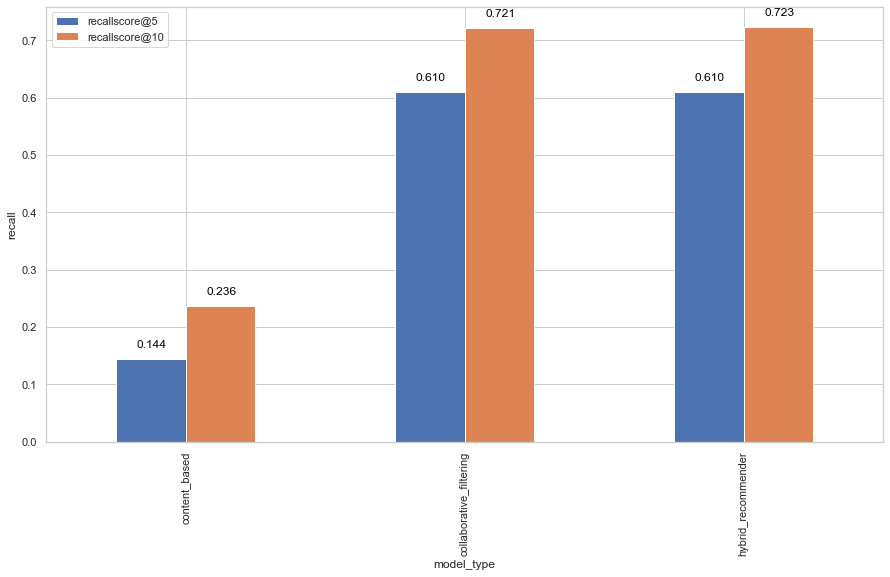

In [11]:
ax = all_models_metrics_df.plot(kind='bar', figsize=(15,8))
kx = -0.05
ky = 0.02
ax.set_ylabel('recall')
for p in ax.patches:
    ax.text(p.get_xy()[0]+kx+p.get_width()/2, p.get_height()+ky, "%.3f" % p.get_height(),fontsize=12, color='black')

In [12]:
all_models_metrics_df_transpose = all_models_metrics_df.transpose()
all_models_metrics_df_transpose

model_type,content_based,collaborative_filtering,hybrid_recommender
recallscore@5,0.144222,0.609838,0.609971
recallscore@10,0.235915,0.721313,0.722582


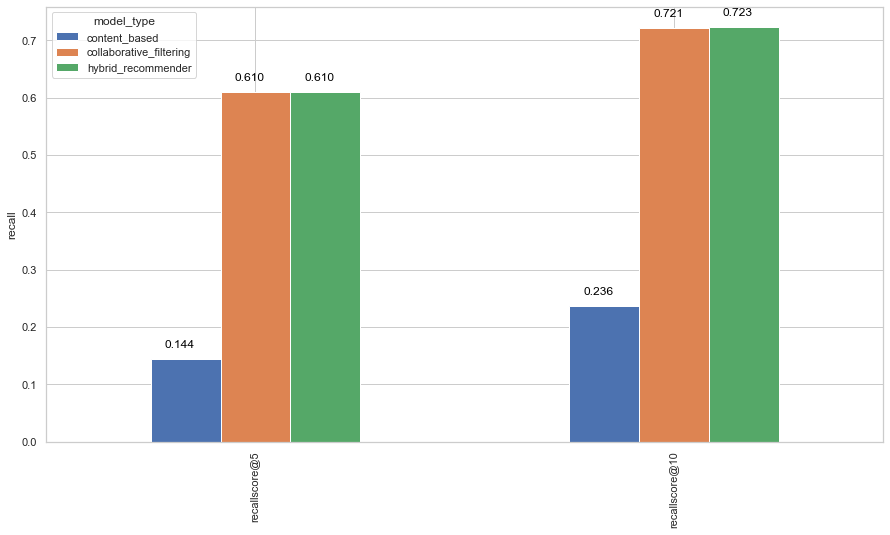

In [13]:
ax = all_models_metrics_df_transpose.plot(kind='bar', figsize=(15,8))
kx = -0.05
ky = 0.02
ax.set_ylabel('recall')
for p in ax.patches:
    ax.text(p.get_xy()[0]+kx+p.get_width()/2, p.get_height()+ky, "%.3f" % p.get_height(),fontsize=12, color='black')

We can see the combined model has slight improvement over individual recommedation model

We will be evaluating the recommendation by Hybrid Recommendation Model. Here we will be evaluating the Hybrid Recommender model for user with id 311. We have evaluated the output from the Collaborative filtering model for same user.

In [14]:
# METHOD      : get_user_recommendation
# INPUTS      : user_id - Id of the user,  topn - number of recommendations needed
# DESCRIPTION : Get the training data. Filter the list of movies wateched by the given user, as part of train data.
#               Invoke hybrid recommender system with given user id and list of movies to be omitted from recommendation
#               Return the recommended dataset.

In [15]:
def get_user_recommendation(user_id, topn = 20):
    user_ratings_train_df = DataGen.train_test_user_behaviour()[0]
    user_specific_interaction_df =user_ratings_train_df[user_ratings_train_df.userId == user_id]
    list_of_interacted_items = list(user_specific_interaction_df.imdbId.unique())
    recomm_df = hybrid_recommender_model.get_item_recommendations(user_id, list_of_interacted_items, topn=20)
    return recomm_df[['imdbId', 'title', 'hybrid_rec_relevance_score']]

In [16]:
user_id = 311
recommendations = get_user_recommendation(user_id, topn=20)
recommendations

,imdbId,title,hybrid_rec_relevance_score
0,118571,Air Force One,63.903970
1,116282,Fargo,59.205544
2,119654,Men in Black,58.860714
3,31381,Gone with the Wind,56.458443
4,107290,Jurassic Park,54.975519
5,108160,Sleepless in Seattle,54.455988
6,114388,Sense and Sensibility,53.547847
7,109830,Forrest Gump,53.378898
8,71562,The Godfather: Part II,52.571905
9,68646,The Godfather,51.860769


Now we will filter the movies which are watched by same user from the test dataset. 
Get the movie details by merging the movie metadata dataset. 

In [17]:
user_ratings_test_df = DataGen.train_test_user_behaviour()[1]
user_specific_interaction_test_df = user_ratings_test_df[user_ratings_test_df.userId == user_id]
movie_dataset = movie_meta_data[['imdbId', 'title']]
user_specific_interaction_test_df = pd.merge(left=user_specific_interaction_test_df, right=movie_dataset, left_on='imdbId', right_on='imdbId')

Let us see how many of the recommeded movies are in the training dataset for the user.

In [18]:
merged_pred_df = pd.merge(left=user_specific_interaction_test_df, right=recommendations, left_on='imdbId', right_on='imdbId')
merged_pred_df

,userId,imdbId,rating,title_x,title_y,hybrid_rec_relevance_score
0,311,32904,2.0,The Philadelphia Story,The Philadelphia Story,50.714121
1,311,118571,4.0,Air Force One,Air Force One,63.903970
2,311,107290,4.5,Jurassic Park,Jurassic Park,54.975519
3,311,114388,2.0,Sense and Sensibility,Sense and Sensibility,53.547847
4,311,110367,3.0,Little Women,Little Women,47.808105
5,311,105435,4.0,Sneakers,Sneakers,51.019550
6,311,125439,5.0,Notting Hill,Notting Hill,49.193891
7,311,109830,5.0,Forrest Gump,Forrest Gump,53.378898
8,311,108160,4.0,Sleepless in Seattle,Sleepless in Seattle,54.455988
9,311,119654,3.0,Men in Black,Men in Black,58.860714


We can see that there are 17 out of 20 recommended movies are part of the training dataset. Wheras collaborative filtering model had only 16.